1-  Importation des bibliothèques

In [6]:
import pandas as pd  # Manipulation et chargement des données
import numpy as np  # Calculs mathématiques et manipulation des matrices
import matplotlib.pyplot as plt  # Création de graphiques pour la visualisation des données
import seaborn as sns  # Visualisation avancée et analyse exploratoire des données

from sklearn.model_selection import train_test_split  # Séparation des données en ensembles d'entraînement et de test
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler  # Encodage des variables catégoriques et normalisation des données

from sklearn.linear_model import LinearRegression  # Modèle de régression linéaire (baseline)
from sklearn.ensemble import HistGradientBoostingRegressor  # Algorithme de boosting optimisé
from xgboost import XGBRegressor  # Algorithme de boosting XGBoost

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score  # Métriques d'évaluation des modèles



2- Chargement et Prétraitement des Données

In [7]:
# Charger le dataset
df = pd.read_csv("Restored_Cleaned_Dataset.csv")

# Sélection des variables pertinentes
X = df.drop(columns=["price", "flight", "Unnamed: 0"])  # Supprimer colonnes inutiles
y = df["price"]

# Séparation en ensemble d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Encodage des variables catégoriques
categorical_columns = ["airline", "source_city", "departure_time", "stops", "arrival_time", "destination_city", "class"]
encoder = OneHotEncoder(sparse_output=False, drop="first")
X_train_encoded = encoder.fit_transform(X_train[categorical_columns])
X_test_encoded = encoder.transform(X_test[categorical_columns])

# Conversion en DataFrame
encoded_columns = encoder.get_feature_names_out(categorical_columns)
X_train_encoded_df = pd.DataFrame(X_train_encoded, columns=encoded_columns, index=X_train.index)
X_test_encoded_df = pd.DataFrame(X_test_encoded, columns=encoded_columns, index=X_test.index)

# Fusionner les données encodées avec les variables numériques
X_train_final = X_train.drop(columns=categorical_columns).reset_index(drop=True)
X_test_final = X_test.drop(columns=categorical_columns).reset_index(drop=True)
X_train_final = pd.concat([X_train_final, X_train_encoded_df.reset_index(drop=True)], axis=1)
X_test_final = pd.concat([X_test_final, X_test_encoded_df.reset_index(drop=True)], axis=1)

# Normalisation des variables numériques
scaler = MinMaxScaler()
X_train_final[["duration", "days_left"]] = scaler.fit_transform(X_train_final[["duration", "days_left"]])
X_test_final[["duration", "days_left"]] = scaler.transform(X_test_final[["duration", "days_left"]])

3- Entraînement et Évaluation des Modèles

3.1 Régression Linéaire (Baseline)

✅ Régression Linéaire - Résultats :
📌 MAE  : 4526.18
📌 RMSE : 6664.38
📌 R²   : 0.9129


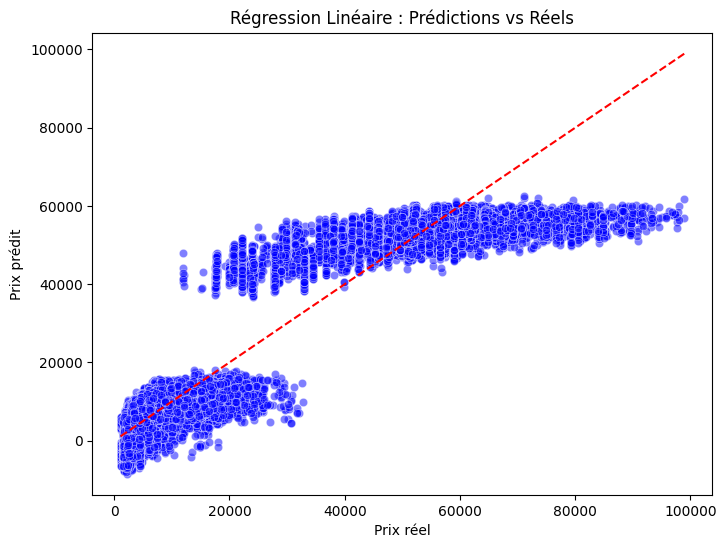

In [19]:
#  Entraînement du modèle
linear_model = LinearRegression()
linear_model.fit(X_train_final, y_train)
y_pred_lr = linear_model.predict(X_test_final)

#  Évaluation du modèle
mae_lr = mean_absolute_error(y_test, y_pred_lr)
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))  # Correction de RMSE
r2_lr = r2_score(y_test, y_pred_lr)

# Affichage des résultats
print(" Régression Linéaire - Résultats :")
print(f" MAE  : {mae_lr:.2f}")
print(f" RMSE : {rmse_lr:.2f}")
print(f" R²   : {r2_lr:.4f}")
# Visualisation des prédictions vs valeurs réelles
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred_lr, alpha=0.5, color="blue")  # Nuage de points
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color="red", linestyle="--")  # Ligne de référence y=x
plt.xlabel("Prix réel")
plt.ylabel("Prix prédit")
plt.title("Régression Linéaire : Prédictions vs Réels")
plt.show()

3.2 XGBoost

XGBoost - Résultats :
MAE  : 2108.47
RMSE : 3664.72
R²   : 0.9737


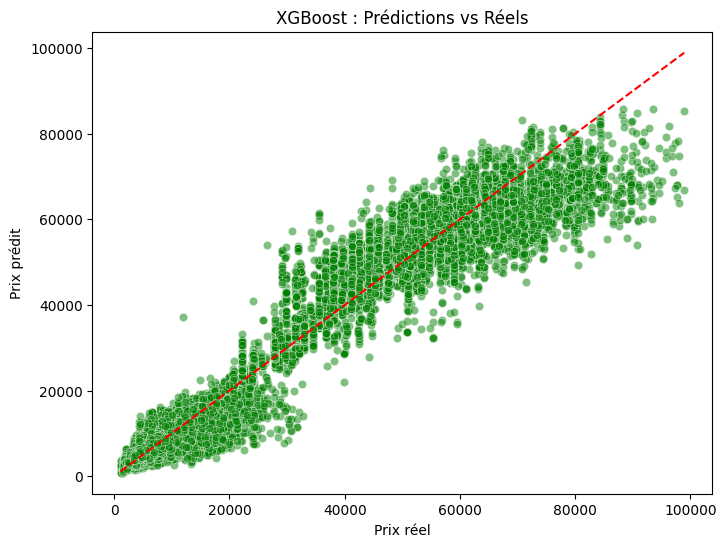

In [20]:
#   initialisation du modèle XGBoost avec des hyperparamètres spécifiques
# - n_estimators=200 : Nombre d'arbres de décision (itérations)
# - learning_rate=0.1 : Taux d’apprentissage, contrôle la vitesse d’adaptation du modèle
# - max_depth=6 : Profondeur maximale des arbres pour éviter le surajustement
# - random_state=42 : Assure la reproductibilité des résultats
# - n_jobs=-1 : Utilise tous les cœurs disponibles du processeur pour accélérer l'entraînement
xgb_model = XGBRegressor(n_estimators=200, learning_rate=0.1, max_depth=6, random_state=42, n_jobs=-1)

#  Entraînement du modèle XGBoost sur l’ensemble d'entraînement
xgb_model.fit(X_train_final, y_train)

#  Prédiction des prix des billets sur l’ensemble de test
y_pred_xgb = xgb_model.predict(X_test_final)

#  Évaluation du modèle avec différentes métriques :
# - MAE (Mean Absolute Error) : Moyenne des erreurs absolues entre prédictions et valeurs réelles
# - RMSE (Root Mean Squared Error) : Erreur quadratique moyenne racine, plus sensible aux grandes erreurs
# - R² (Coefficient de détermination) : Proportion de variance expliquée par le modèle (proche de 1 = bon modèle)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
r2_xgb = r2_score(y_test, y_pred_xgb)

# Affichage des performances du modèle XGBoost
print("XGBoost - Résultats :")
print(f"MAE  : {mae_xgb:.2f}")  # Erreur absolue moyenne
print(f"RMSE : {rmse_xgb:.2f}")  # Erreur quadratique moyenne racine
print(f"R²   : {r2_xgb:.4f}")  # Score R²

#  Visualisation des prédictions vs valeurs réelles
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred_xgb, alpha=0.5, color="green")  # Nuage de points entre prix réel et prédit
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color="red", linestyle="--")  # Ligne idéale
plt.xlabel("Prix réel")
plt.ylabel("Prix prédit")
plt.title("XGBoost : Prédictions vs Réels")
plt.show()  # Affichage du graphique


3.3 HistGradientBoosting

HistGradientBoosting - Résultats :
MAE  : 1922.13
RMSE : 3338.91
R²   : 0.9781


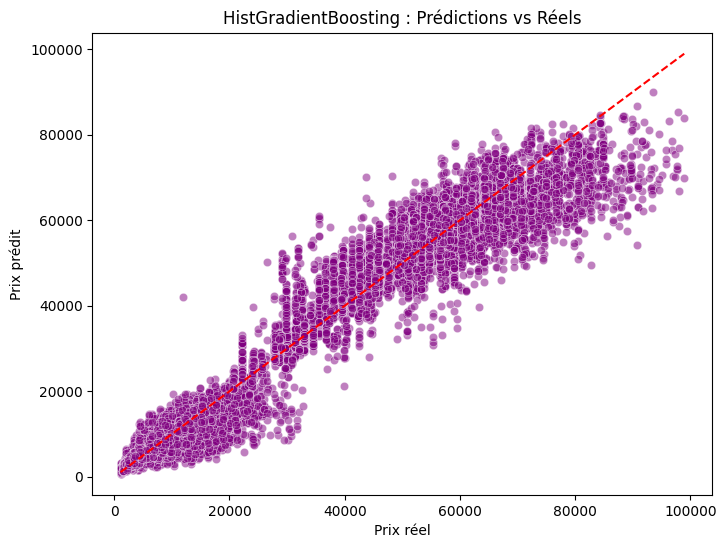

In [22]:
#  Initialisation du modèle HistGradientBoosting avec des hyperparamètres spécifiques
# - max_iter=500 : Nombre maximal d'itérations (arbres)
# - learning_rate=0.1 : Taux d’apprentissage pour ajuster progressivement le modèle
# - max_depth=7 : Profondeur maximale des arbres pour capturer des relations complexes
# - random_state=42 : Garantit la reproductibilité des résultats
hgb_model = HistGradientBoostingRegressor(max_iter=500, learning_rate=0.1, max_depth=7, random_state=42)

# Entraînement du modèle HistGradientBoosting sur l’ensemble d'entraînement
hgb_model.fit(X_train_final, y_train)

# Prédiction des prix des billets sur l’ensemble de test
y_pred_hgb = hgb_model.predict(X_test_final)

# Évaluation du modèle avec différentes métriques :
# - MAE (Mean Absolute Error) : Moyenne des erreurs absolues entre prédictions et valeurs réelles
# - RMSE (Root Mean Squared Error) : Erreur quadratique moyenne racine, plus sensible aux grandes erreurs
# - R² (Coefficient de détermination) : Proportion de variance expliquée par le modèle (proche de 1 = bon modèle)
mae_hgb = mean_absolute_error(y_test, y_pred_hgb)
rmse_hgb = np.sqrt(mean_squared_error(y_test, y_pred_hgb))
r2_hgb = r2_score(y_test, y_pred_hgb)

# Affichage des performances du modèle HistGradientBoosting
print("HistGradientBoosting - Résultats :")
print(f"MAE  : {mae_hgb:.2f}")  # Erreur absolue moyenne
print(f"RMSE : {rmse_hgb:.2f}")  # Erreur quadratique moyenne racine
print(f"R²   : {r2_hgb:.4f}")  # Score R²

# Visualisation des prédictions vs valeurs réelles
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred_hgb, alpha=0.5, color="purple")  # Nuage de points entre prix réel et prédit
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color="red", linestyle="--")  # Ligne idéale
plt.xlabel("Prix réel")
plt.ylabel("Prix prédit")
plt.title("HistGradientBoosting : Prédictions vs Réels")
plt.show()  # Affichage du graphique


4- Visualisation des Résultats

<ipython-input-26-39b54407cccd>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=models, y=r2_values, palette="Greens")  # Graphique à barres pour comparer les scores R²


<Figure size 1200x600 with 0 Axes>

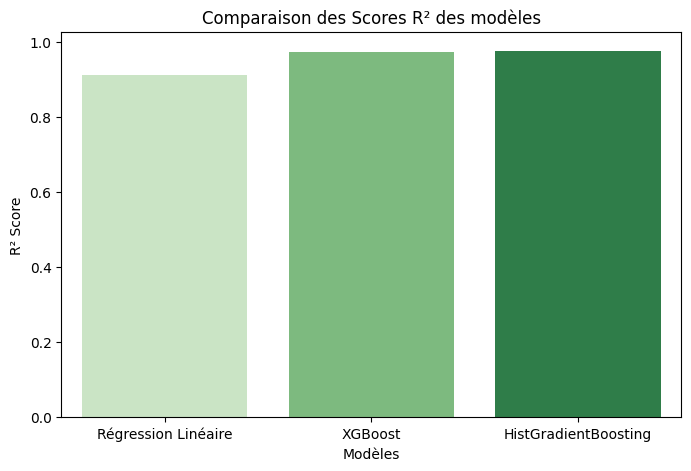

In [26]:
# Comparaison des erreurs entre les modèles
models = ["Régression Linéaire", "XGBoost", "HistGradientBoosting"]

# Stocker les valeurs des erreurs et du score R² pour chaque modèle
mae_values = [mae_lr, mae_xgb, mae_hgb]  # Erreur absolue moyenne
rmse_values = [rmse_lr, rmse_xgb, rmse_hgb]  # Erreur quadratique moyenne racine
r2_values = [r2_lr, r2_xgb, r2_hgb]  # Score de détermination R²

# Création de la figure pour la visualisation
plt.figure(figsize=(12, 6))

# Affichage des scores R² sous forme de diagramme en barres
plt.figure(figsize=(8, 5))  # Définition de la taille du graphique
sns.barplot(x=models, y=r2_values, palette="Greens")  # Graphique à barres pour comparer les scores R²
plt.title("Comparaison des Scores R² des modèles")  # Titre du graphique
plt.ylabel("R² Score")  # Étiquette de l'axe Y
plt.xlabel("Modèles")  # Étiquette de l'axe X
plt.show()  # Affichage du graphique
